# Projet numérique: lignes de niveau 
### par Hugo TISSOT et Victor GAUTIER 

## I. Elaboration de la fonction ```contour_simple```

### 1. Principe 

Pour tracer les lignes de niveau d'une fonction de deux variables, nous utiliserons le résultat suivant: 
> le gradient de *f* est perpendiculaire en tout point à la ligne de niveau de *f* en ce point.

Les étapes du code seront les suivantes:
* détermination du vecteur dirigeant la perpendiculaire au gradient en un point de la ligne de niveau 
* calcul de deux points potentiels de la ligne de niveau se trouvant sur cette droite
* choix de l'un d'eux en fonction de la position du point précédent 
* correction de la position du point choisi avec la méthode de Newton (On recalcule le gradient au niveau du nouveau point et on se déplace dans sa direction pour se rapprocher de la valeur de la ligne de niveau afin d'éviter que l'erreur puisse se propager)

### 2. Implémentation détaillée par fonctions 

$ \text{On étudie la fonction }f\,:(x,y) \mapsto 2\,(exp(-x^2-y^2)-exp(-(x-1)^2-(y-1)^2))$

In [ ]:
import sys
sys.path

In [47]:
#On importe tous les modules utiles pour la suite
#python -m pip install autograd
import matplotlib.pyplot as plt
import matplotlib
import autograd
from autograd import numpy as np

In [2]:
#Soit en code:
def f(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

   #### a. La fonction ```find_seed```

**Théorème des valeurs intermédiaires:** 
> $\text{Soit f une fonction continue à valeurs réelles sur [a,b] et y tel que } f(a) \leq y \leq f(b) \text{ ou } f(b) \leq y \leq f(a)\text{ .   } 
\exists x \in [a,b]  \text{ | }f(x)=y$ 



On réalise une dichotomie pour trouver un point se situant sur la ligne de niveau souhaitée à partir de l'arrête gauche de la cellule $[0,1]\times [0,1]$.
On utilise donc la condition suffisante $f(0) \leq c \leq f(1) \text{ ou } f(1) \leq c \leq f(0)$ pour s'assurer de  son bon fonctionnement. 

In [3]:
#Code:
def find_seed(f,c=0,eps=2**(-26)):
    if not (f(0,0)<=c<=f(0,1) or f(0,1)<=c<=f(0,0)):  #Si pas de solution sur l'arrête gauche
        return "Rien"
    g=lambda y: f(0.0,y)-c
    a=0
    b=1
    while (b-a)/2>eps:
            t=(a+b)/2
            if g(a)*g(t)>0:
                a=t
            else:
                b=t
    return (0.0,(a+b)/2)

#### b. La fonction ```grad_f``` 

In [4]:
def grad_f(x,y):                          #Gradient de f au point (x,y)
        g=autograd.grad
        return np.r_[g(f,0)(x,y),g(f,1)(x,y)]

#### c. La fonction ```perp_grad``` 

In [5]:
def perp_grad(a,f,delta):           #Cette fonction calcule le vecteur dirigeant la perpendiculaire au gradient évalué en a 
    grad=grad_f(a[0],a[1])
    if grad[0]==0:                  #On utilise le fait que si (grad[0],grad[1]) est normal à (x,y) alors grad[0]x+grad[1]y=0 
        vecteur=np.array([delta,0]) #On choisit donc un vecteur (x,y) qui convient  
    elif grad[1]==0:
        vecteur=np.array([0,delta])
    else:
        vecteur=np.array([1/grad[0],-1/grad[1]])
        vecteur=delta/np.linalg.norm(vecteur)*vecteur
    return vecteur

#### d. La fonction ```parcourir``` 

In [6]:
def parcourir(v,p) :           #Fonction qui génère les 2 points potentiels pour continuer la ligne de niveau                      
    p1 = (p[0]+v[0],p[1]+v[1])
    p2 = (p[0]-v[0],p[1]-v[1])
    return p1,p2

#### e. La fonction ```choix```

In [7]:
def choix(a,precedent,p1,p2) :                           #Cette fonction choisit lequel des 2 points sera choisi pour la suite du tracé                                               
    v = np.array([a[0]-precedent[0],a[1]-precedent[1]])  #P1 et P2 sont les points suivants potentiels, M le point 
    u1 = np.array([p1[0]-a[0],p1[1]-a[1]])               #au niveau de la tangente et N le point qui le précède
    u2 = np.array([p2[0]-a[0],p2[1]-a[1]])
    if np.vdot(u1,v) >= 0 :                              #On effectue un produit scalaire 
        return (p2)
    if np.vdot(u2,v) >= 0 :
        return (p1)

#### f. La fonction ```compose```

In [8]:
def compose(p,delta,f,c,grad_p):         #Cette fonction évalue f sur un segment paramétré centré sur p 
    def composed(t):
        a=(p-grad_p/np.linalg.norm(grad_p)*delta)*t+(p+grad_p/np.linalg.norm(grad_p)*delta)*(1-t)
        return f(a[0],a[1])-c
    return composed 

#### g. La fonction ```newton``` 

In [9]:
def newton (f ,df,t0=0.5 , prec =0.0001): #t0 est le paramètre du segment 
    z = f(t0)
    dz = df (t0)
    iprec = 1/prec
    while abs (z) > prec and dz < iprec:
        t0 = t0 - z/dz
        z = f(t0)
        dz = df(t0)
    return t0

### 3. Implémentation 

In [44]:
def simple_contour(f,c=0.0,delta=0.01):
    xs=[]
    ys=[]
    if find_seed(f,c) == "Rien":
        return [],[]
    p_fin=find_seed(f,c)
    while 0<=p_fin[0]<=1 and 0<=p_fin[1]<=1: #La fonction s'arrête quand le point calculé sort de la cellule
        vecteur=perp_grad(p_fin,f,delta)
        p1,p2=parcourir(vecteur,p_fin)

        if xs==[]:
            p=p2
            xs.append(p_fin[0])
            ys.append(p_fin[1])

        else:
            p=choix(p_fin,(xs[-1],ys[-1]),p1,p2)

        grad_p=grad_f(p[0],p[1])

        f_compose=compose(p,delta,f,c,grad_p)
        deriv_compose=autograd.grad(f_compose)
        t0=newton(f_compose,deriv_compose)
        p_fin=(p-grad_p/np.linalg.norm(grad_p)*delta)*t0+(p+grad_p/np.linalg.norm(grad_p)*delta)*(1-t0)
        xs.append(p_fin[0])
        ys.append(p_fin[1])
    return xs,ys


In [11]:
from matplotlib import pyplot as plt
%matplotlib inline


#### On effectue alors le tracé pour des valeurs pertinentes (de -1.5 à 1.5 avec un pas de 0.5)

Text(0.5, 1.0, 'matplotlib')

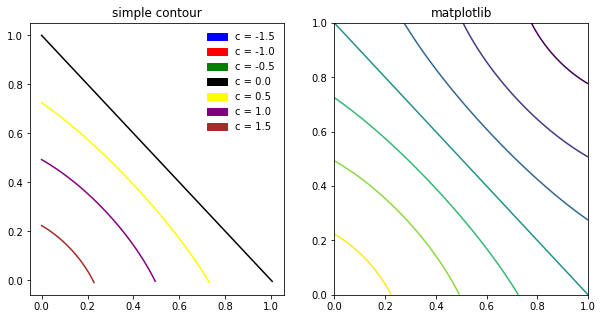

In [50]:
couleurs = ["blue","red","green","black","yellow","purple","brown"]
rectangles = []
textes = []
fig = plt.figure(1,figsize = (10,5))
plt.subplot(1,2,1)
for i,col in enumerate(couleurs) :
    x,y = simple_contour(f,-1.5 + 0.5*i)
    plt.plot(x,y,color = col)
    rec = matplotlib.patches.Rectangle((i*0.5,0),0,0,color = col)
    rectangles.append(rec)
    textes.append("c = "+str(-1.5 + i*0.5))
plt.legend(rectangles,textes,markerscale = 20,frameon = False, fontsize = 10,loc="best")
plt.title("simple contour")
plt.subplot(1,2,2)
x , y = np.meshgrid(np.linspace(0,1,201),np.linspace(0,1,201))
z = f(x,y)
cont = plt.contour(x,y,z,levels = [-1.5,-1,-0.5,0,0.5,1,1.5])
plt.title('matplotlib')
    

#### On remarque que les seuls tracé obtenus sont ceux intersectant la gauche du cadre, ceci s'explique par l'implémentation de la fonction find_seed ne cherchant qu'une solution sur l'axe x=0. Ce problème sera résolu par une rotation implémentée dans la fonction finale contour complexe.
#### Toutefois les résultats pour les valeurs de [0;1.5] semblent correspondre aux tracés théoriquement attendus, on peut donc passer au cas général avec des cellules de plus grande taille.

## II. Fonction contour complexe

In [14]:
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.005):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append((xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve))
    return curves


#### Voici le tracé des lignes de niveau pour 7 valeurs distinctes (de -1.5 à 1.5 avec un pas de 0.5). L'éxécution du programme peut être un peu longue.

C:\Users\hugot\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\hugot\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in add
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hugot\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in add
C:\Users\hugot\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


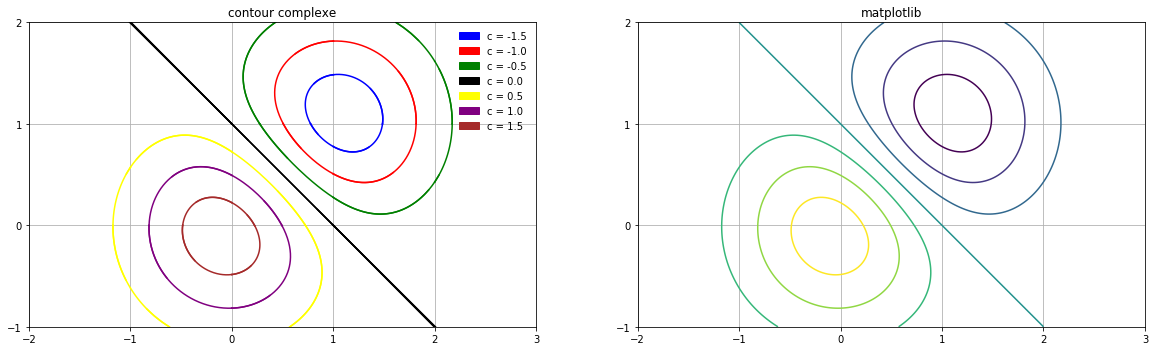

In [42]:
couleurs = ["blue","red","green","black","yellow","purple","brown"]
rectangles = []
textes = []
xs = [-2, -1, 0, 1, 2, 3]
ys = [-1, 0, 1, 2]
fig = plt.figure(1, figsize = (20,20))
plt.subplot(1,2,1)
for i,col in enumerate(couleurs) :
    level_curves = contour(f, -1.5 + i*0.5, xs, ys)
    for x, y in level_curves:
        plt.plot(x, y, color = col)
    rec = matplotlib.patches.Rectangle((i*0.5,0),0,0,color = col)
    rectangles.append(rec)
    textes.append("c = "+str(-1.5 + i*0.5))
plt.legend(rectangles,textes,markerscale = 20,frameon = False, fontsize = 10,loc="best")

plt.xlim(-2, 3)
plt.ylim(-1, 2)
plt.xticks(xs)
plt.yticks(ys)
plt.grid(True)
plt.gca().set_aspect("equal")
plt.title("contour complexe")
plt.subplot(1,2,2)
x , y = np.meshgrid(np.linspace(-2,3,201),np.linspace(-1,2,201))
z = f(x,y)

cont = plt.contour(x,y,z,levels = [-1.5,-1,-0.5,0,0.5,1,1.5])
plt.xlim(-2, 3)
plt.ylim(-1, 2)
plt.xticks(xs)
plt.yticks(ys)
plt.grid(True)
plt.gca().set_aspect("equal")
plt.title('matplotlib')
plt.show()
